In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
import os
import glob
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm
from scipy import interpolate
import itertools

from utils_analysis import *
from PIL import Image
from scipy.stats import gaussian_kde

In [2]:
plt.rcParams["font.family"] = "Arial" 
#plt.rcParams['axes.spines.right'] = False
#plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

In [3]:
def delete_nan(arr):
    return arr[~np.isnan(arr)]

def plot_scatter_density(x, y, ax, cmap, marker, s, alpha):
    # Calculate the point density
    nan_idx = np.isnan(x) | np.isnan(y)
    x = x[~nan_idx]
    y = y[~nan_idx]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    ax.scatter(x, y, c=z, cmap=cmap, marker=marker, s=s, alpha=alpha, rasterized=False)#True)

def im2gray(im):
    if im.mode != "RGB":
        im = im.convert("RGB") # any format to RGB
    rgb = np.array(im, dtype="float32");
    
    rgbL = pow(rgb/255.0, 2.2)
    r, g, b = rgbL[:,:,0], rgbL[:,:,1], rgbL[:,:,2]
    grayL = 0.299 * r + 0.587 * g + 0.114 * b  # BT.601
    gray = pow(grayL, 1.0/2.2)*255
    
    im_gray = Image.fromarray(gray.astype("uint8"))
    return im_gray

In [4]:
fps = 29.93

In [5]:
s_f = [327, 1124, 2004]
v_i = [3, 7, 11]
#s_f = [1, 156, 554]
#v_i = [1, 2, 4]

In [6]:
preproceeed_data_path = "../dataset/Nakano_etal_2010/preprocessed_data"

In [7]:
training_methods = ["dino", "supervised"] 
depth_list = [4, 8, 12]
num_models = 6
num_heads = 6

In [8]:
vit_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/vit_gaze_pos.npz", allow_pickle=True)
vit_official_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/vit_official_gaze_pos.npz", allow_pickle=True)
gbvs_gaze_pos = np.load("../dataset/Nakano_etal_2010/preprocessed_data/gbvs_gaze_pos.npz", allow_pickle=True)

In [9]:
gbvs_gaze_pos["labels"]#.files

array(['All', 'Intensity', 'Orientation', 'Contrast', 'Flicker', 'Motion',
       'DKL_Color'], dtype='<U11')

In [10]:
subj_gazepos_data = np.load("../dataset/Nakano_etal_2010/preprocessed_data/goodsubj_gaze_pos.npz", allow_pickle=True)
gazepos_goodsubj = subj_gazepos_data['gaze_data_goodsubj']
gr_goodsubj = subj_gazepos_data['gr_goodsubj']
group_name = subj_gazepos_data['group_name']

In [11]:
patch_size = 16
group_name = ["TD adults", "TD children", "DINO ViT (G1)"]
gr_indices = [0, 1, 4, 3]

In [12]:
frame_indices = [480, 1180, 2070]#
frame_reindices = [np.floor(frame_idx * 3883 / 2327).astype(int) for frame_idx in frame_indices]
gazepos_subj_slice = [gazepos_goodsubj[:, frame_reidx] for frame_reidx in frame_reindices]

In [13]:
# subj data
#blur_imgs = [Image.open("../figures/masked_frames/frame{0:04}_masked.png".format(frame_idx)) for frame_idx in frame_indices]
blur_imgs = [Image.open("../figures/masked_frames/frame{0:04}_masked.png".format(frame_idx)) for frame_idx in frame_indices]

In [14]:
head_GMM_label = np.load("../results/head_GMM_label.npz", allow_pickle=True)
layer_indices = head_GMM_label["layer_indices"].astype(int)
"""
label_rank = head_GMM_label["label_rank"].astype(int)
head_label = head_GMM_label["head_label"].astype(int)
head_label_proba = head_GMM_label["head_label_proba"]
num_groups = len(np.unique(label_rank))
"""
head_label = np.load("../results/attn_best_label_N2010.npy").astype(int).reshape(4, 6, 6)

In [15]:
frame_idx = frame_indices[-1]
img_idx = 2
gaze_pos_dict = {}
for j, gn in enumerate(group_name):
    x, y = [], []
    if j < 2:
        #for i, gr_idx in enumerate(gr_indices[j*2:(j+1)*2]):
        gr_idx  = gr_indices[j]
        gr_slice = gr_goodsubj == gr_idx
        gaze_pos_dict[gn] = pd.DataFrame(gazepos_subj_slice[img_idx][gr_slice]).dropna().values
    else:
        vit_pos = []
        tm = training_methods[0]
        sigma = patch_size/6
        for i, depth in enumerate(depth_list[1:]):
            gaze_pos_depth = vit_gaze_pos[tm].item()[str(depth)]
            d_indices = layer_indices[layer_indices[:, 0] == depth][:,1]
            for m_idx in range(num_models):
                for j, d_idx in enumerate(d_indices):
                    ij = i * 2 + j
                    for h_idx in range(num_heads):
                        hl = head_label[ij, m_idx, h_idx]
                        if hl == 1:
                            #if label_rank[hl] == 0:
                            vit_pos.append(gaze_pos_depth[m_idx, d_idx, h_idx, frame_idx])
        vit_pos = np.stack(vit_pos)
        vit_pos += np.random.randn(len(vit_pos), 2) * sigma
        gaze_pos_dict[gn] = vit_pos

In [16]:
blur_imgs_gray = [im2gray(im) for im in blur_imgs]

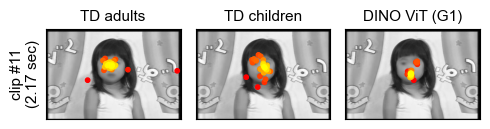

In [17]:
alpha = 1
fig, axes = plt.subplots(1, 3, figsize=(5, 2), tight_layout=True)
frame_idx = frame_indices[-1]
img_idx = 2
axes[0].set_ylabel(f"clip #{v_i[img_idx]}\n({(frame_indices[img_idx] - s_f[img_idx] - 1)/fps:.2f} sec)", fontsize=11)
for j, gn in enumerate(group_name):
    pos = gaze_pos_dict[gn]
    plot_scatter_density(pos[:, 0], pos[:, 1], axes[j], cmap='autumn', marker="o", s=10, alpha=1)
    axes[j].imshow(blur_imgs_gray[img_idx], cmap="gray")
    #axes[j, img_idx].imshow(blur_imgs[img_idx])
    axes[j].set_title(gn, fontsize=11)#, rotation=0, ha='center', va='center', labelpad=25)
    axes[j].set_xticks([])
    axes[j].set_yticks([])
plt.tight_layout()
fig.savefig("../figures/gaze_key_points_examples.svg", bbox_inches='tight', dpi=300)

In [ ]:
alpha = 1
fig, axes = plt.subplots(1, 3, figsize=(5, 2), tight_layout=True)
frame_idx = frame_indices[-1]
img_idx = 2
axes[0].set_ylabel(f"clip #{v_i[img_idx]}\n({(frame_indices[img_idx] - s_f[img_idx] - 1)/fps:.2f} sec)", fontsize=11)
for j, gn in enumerate(group_name):
    pos = gaze_pos_dict[gn]
    #plot_scatter_density(pos[:, 0], pos[:, 1], axes[j], cmap='autumn', marker="o", s=10, alpha=1)
    axes[j].imshow(blur_imgs_gray[img_idx], cmap="gray")
    #axes[j, img_idx].imshow(blur_imgs[img_idx])
    axes[j].set_title(gn, fontsize=11)#, rotation=0, ha='center', va='center', labelpad=25)
    axes[j].set_xticks([])
    axes[j].set_yticks([])
plt.tight_layout()
fig.savefig("../figures/gaze_key_points_examples.svg", bbox_inches='tight', dpi=300)